In [2]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > dataset.zip

In [3]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [214]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [105]:
!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

In [106]:
wandb.init(project="Assignment 2", entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#Project Parameters

In [6]:
path_train_data = os.getcwd()+"/inaturalist_12K/train"
path_test_data = os.getcwd()+"/inaturalist_12K/val"

width, height = 200, 200

batch_size = 128

#Model

Flexible method such that the number of filters, size of filters and activation function in each layer can be changed.


In [7]:
def get_model(filter_list=[64, 32, 48, 32, 32], dropout=0.2, batch_norm=False, dense_layer_size=512, conv_activations=["relu", "relu", "relu", "relu", "relu"], dense_layer_activation="relu", output_activation="softmax"):
    
    model = Sequential()

    for i in range(5):
        model.add(Conv2D(filter_list[i], (3, 3), input_shape=(200,200,3), padding="same"))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation(conv_activations[i]))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_layer_size))
    model.add(Dropout(dropout))
    model.add(Activation(dense_layer_activation))
    model.add(Dense(10))
    model.add(Activation(output_activation))

    return model;

#Data Set

In [8]:
def get_dataset_generators(train_data_aug=False):
    if train_data_aug:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1,               #10% is to be kept aside
            horizontal_flip=True,
            vertical_flip=False,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.1,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    else:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1                 #10% is to be kept aside
        )
    
    test_idg = ImageDataGenerator(
            rescale=1. /255
        )
    
    print(f"{path_train_data}")
    train_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='training',
        class_mode='categorical'
    )

    val_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='validation',
        class_mode='categorical'
    )

    print(f"{path_test_data}")
    test_generator = test_idg.flow_from_directory(
        path_test_data,
        batch_size=batch_size, 
        target_size=(width, height)
    )
    
    return train_generator, val_generator, test_generator

In [14]:
default_config = {
        "filter_list":[64, 32, 48, 32, 32], 
        "dropout":0.2, 
        "batch_norm":False, 
        "dense_layer_size":512,
        "epochs": 10,
        "lr": 0.001,
        "train_data_aug":False
    }

#Keras callback    
history = History()

In [9]:
def run():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    wandb.init(config=default_config, magic=True, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size)

    plot_model(model)

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback(), history])

    # model.evaluate(test_generator)

    # model.save(f'{run_name.replace(",","-")}.h5')  # creates a HDF5 file 'my_model.h5'

In [10]:
sweep_config = {
    "name": "Assignment 2 - alpha",
    "metric": "categorical_accuracy",
    "method": "random",
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64, 64, 48, 32, 32], [128, 64, 48, 32, 32], [32, 32, 32, 32, 32], [64, 64, 64, 64, 64]]
        },
        "dropout": {
            "values": [0.2, 0.3, 0.5]
        },
        "batch_norm": {
            "values": [True, False]
        },
        "dense_layer_size": {
            "values": [512, 1024]
        },
        "train_data_aug": {
            "values": [True, False]
        },
        "epochs": {
            "values": [1, 5, 7]
        },
        "lr": {
            "values": [0.001, 0.0001, 0.00001, 0.01]
        },
        
    }
}

In [11]:
# sweep_id = wandb.sweep(sweep_config, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

In [12]:
# wandb.agent("krsx2rw8", function=run, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

More Specific Search

In [22]:
sweep_config_v2 = {
    "name": "Assignment 2 - beta",
    "metric": "categorical_accuracy",
    "method": "random",
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64, 64, 64, 64, 64]]
        },
        "dropout": {
            "values": [0.2, 0.3, 0.5]
        },
        "batch_norm": {
            "values": [False]
        },
        "dense_layer_size": {
            "values": [1024]
        },
        "train_data_aug": {
            "values": [True]
        },
        "epochs": {
            "values": [10]
        },
        "lr": {
            "values": [0.001, 0.0001]
        },
        
    }
}

In [14]:
def test():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    wandb.init(config=default_config, magic=True, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size)

    plot_model(model, to_file="temp.png")

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=test_generator, callbacks=[WandbCallback()])

In [23]:
# sweep_id = wandb.sweep(sweep_config_v2, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

Create sweep with ID: avdvoeab
Sweep URL: https://wandb.ai/iitm-cs6910-jan-may-2021-cs20m059-cs20m007/Assignment%202/sweeps/avdvoeab


In [24]:
# wandb.agent(sweep_id, function=test, project='Assignment 2', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

wandb: Agent Starting Run: 83lma850 with config:
wandb: 	batch_norm: False
wandb: 	dense_layer_size: 1024
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_list: [64, 64, 64, 64, 64]
wandb: 	lr: 0.0001
wandb: 	train_data_aug: True


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        3

wandb: Ctrl + C detected. Stopping sweep.


In [15]:
# Create a MirroredStrategy.
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
    strategy = tf.distribute.get_strategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope and create the model
with strategy.scope():
    model = get_model([128, 64, 64, 48, 64], 0.2, True, 1024)

plot_model(model)

model.summary()

train_generator, val_generator, test_generator = get_dataset_generators(True)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics="accuracy")

model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[history])

model.evaluate(test_generator)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 200, 200, 128)     3584      
_________________________________________________________________
batch_normalization_25 (Batc (None, 200, 200, 128)     512       
_________________________________________________________________
activation_35 (Activation)   (None, 200, 200, 128)     0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 100, 100, 64)      73792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 100, 100, 64)      256     

[2.143887519836426, 0.3165000081062317]

# Sample images from the test data and predictions made by our best model.

In [84]:
classes = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}

images, labels = test_generator.next()
predictions = model(images)

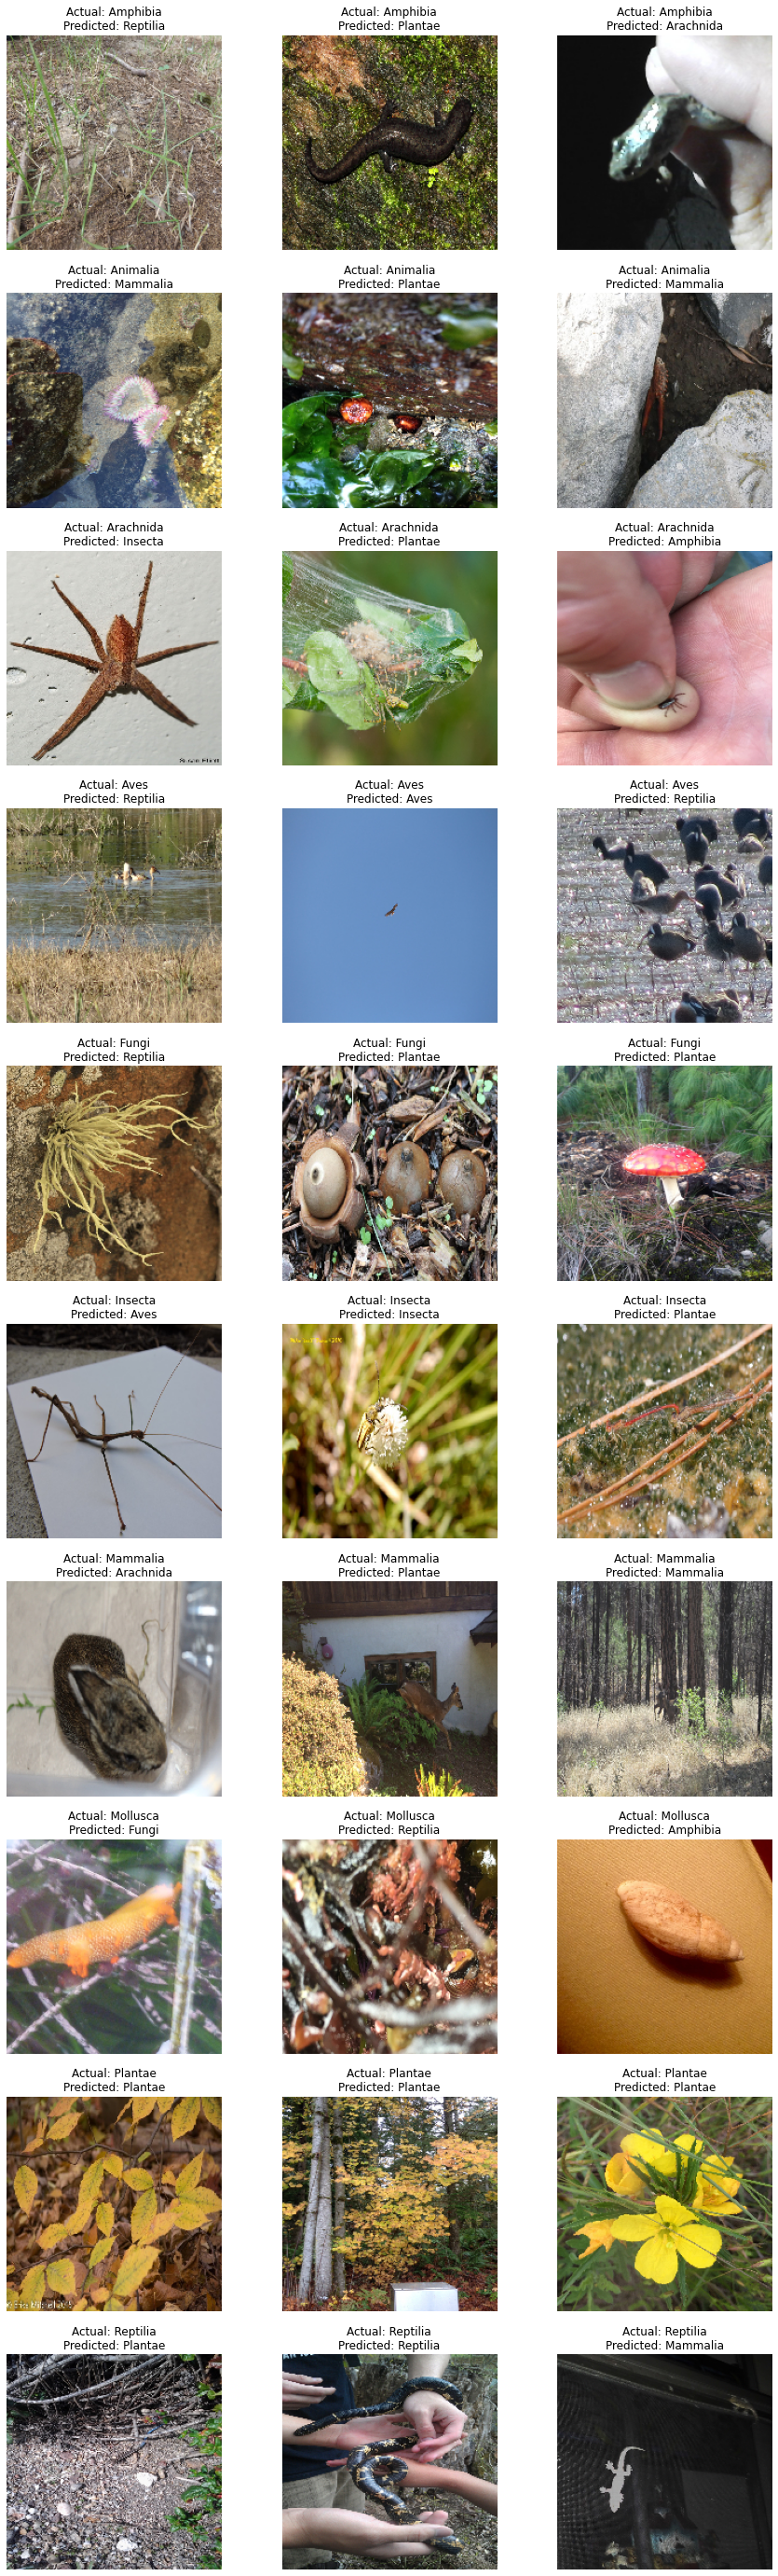

In [126]:
count = [0]*10
images_list = []
f, a = plt.subplots(nrows=10, ncols=3, figsize=(15,50))
for i, img in enumerate(images):
    class_label = np.argmax(labels[i], axis=0)
    pred_label = np.argmax(predictions[i], axis=0)
    if count[class_label] < 3:
        a[class_label, count[class_label]].imshow(img)
        a[class_label, count[class_label]].axis('off')
        ttl = "Actual: " + classes[class_label] + "\nPredicted: " + classes[pred_label]
        a[class_label, count[class_label]].set_title(ttl)
        count[class_label] += 1
        images_list.append((img, ttl))
plt.show()

# Visualise all the filters in the first layer of your best model for a random image from the test set

In [187]:
layer_outputs = [layer.output for layer in model.layers]

activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [195]:
activations = activation_model.predict(images[55:56])

In [196]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 200, 200, 128)


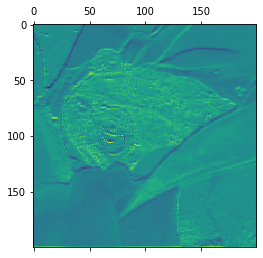

In [207]:
plt.matshow(first_layer_activation[0, :, :, 127])

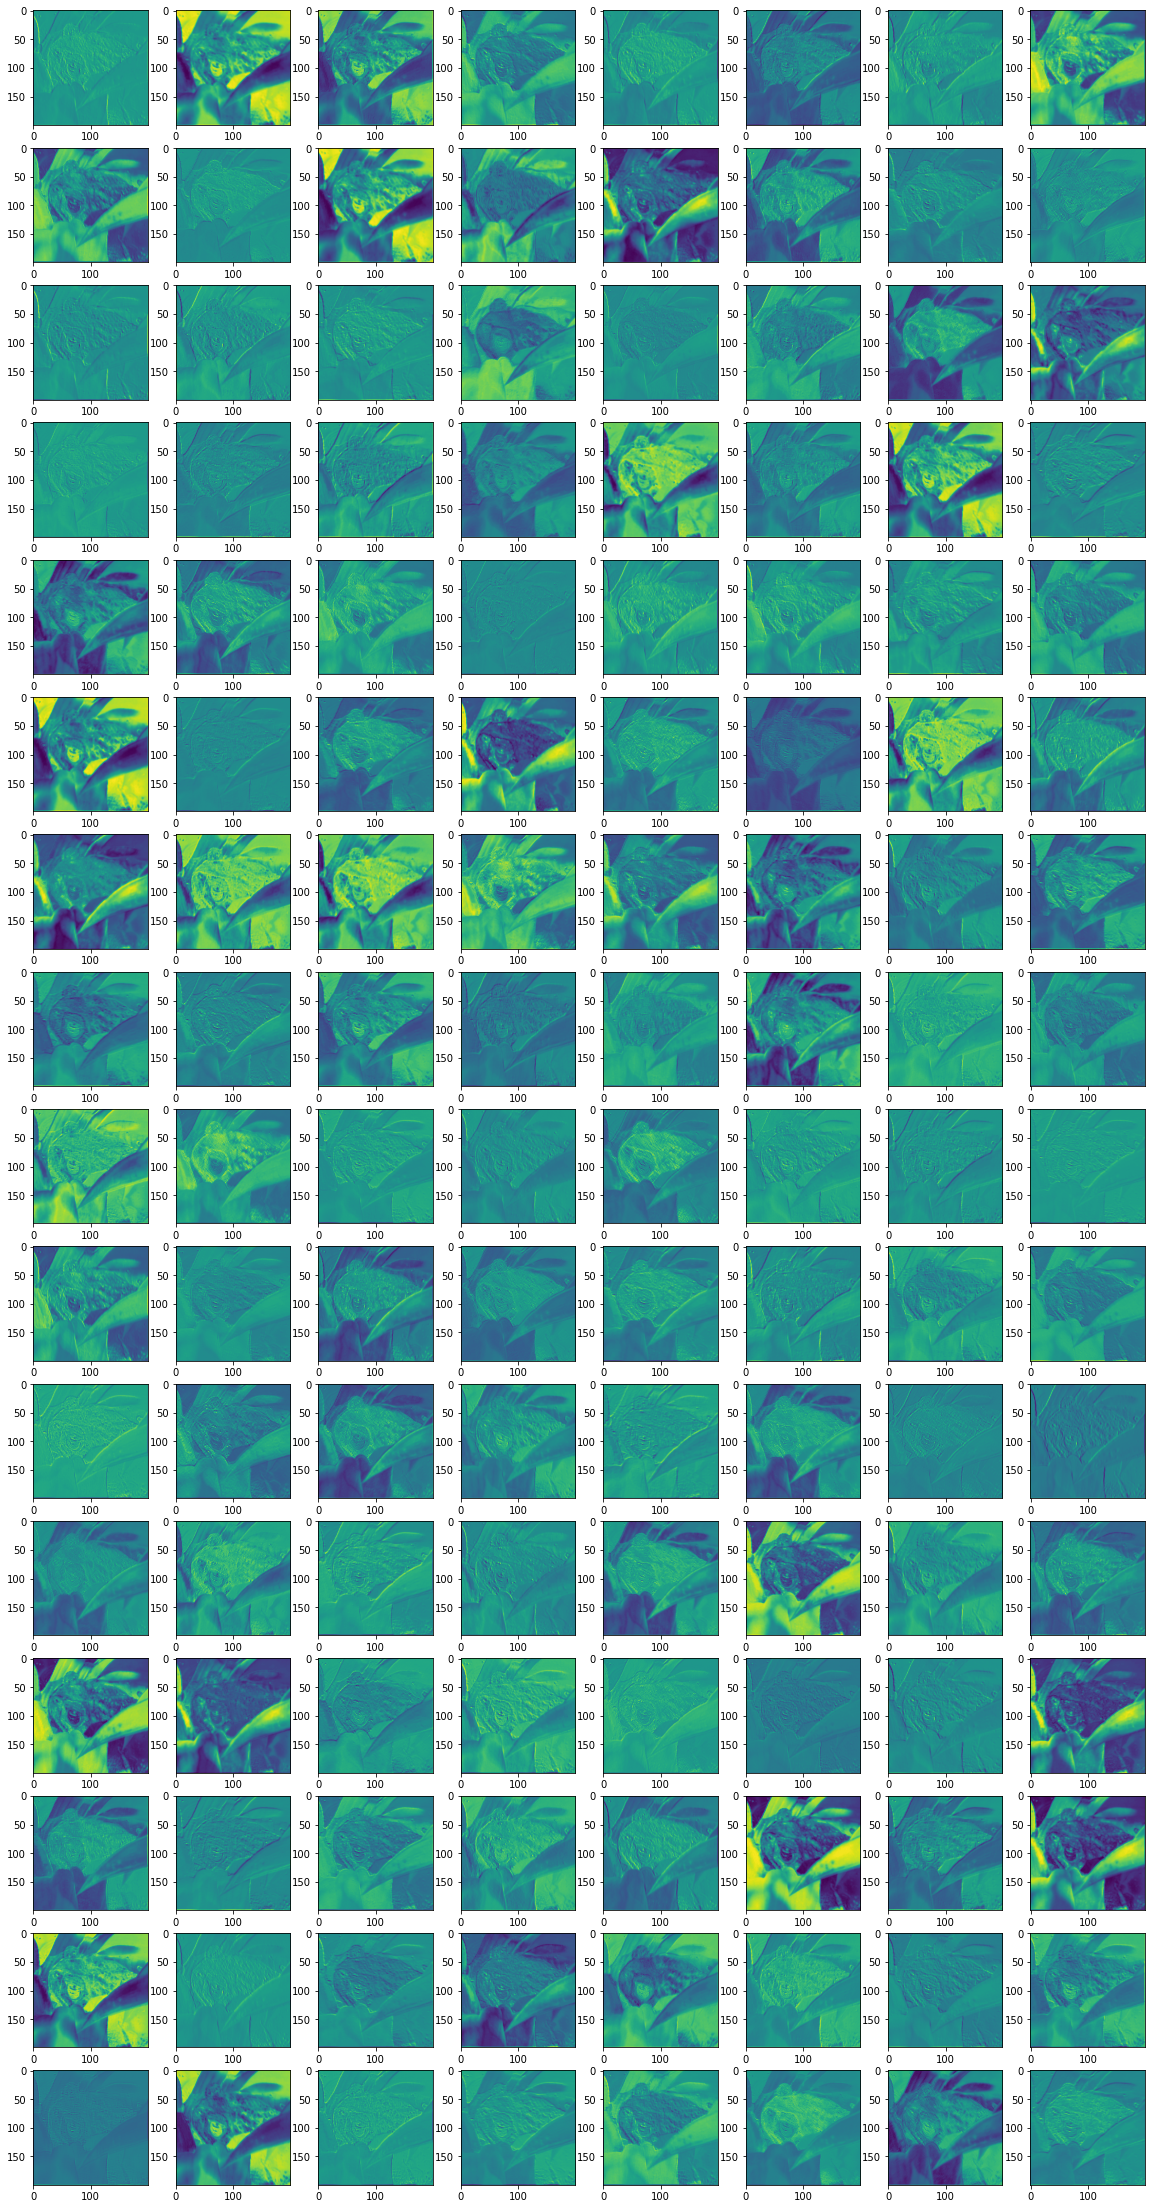

In [213]:
plt.figure(figsize=(20,40))
for d in range(128):
  plt.subplot(16, 8, d+1)
  plt.imshow(first_layer_activation[0, :, :, d])
  wandb.log({"Filters": wandb.Image(first_layer_activation[0, :, :, d])})
plt.savefig("filters.png")
plt.show()

In [216]:
filters_img = Image.open("filters.png") 
wandb.log({"Filters of Layer 1": wandb.Image(filters_img)})